# Notebook 2: Data Cleaning & Preprocessing

**Preparing Data for Factor Analysis**

This notebook implements the data cleaning procedures used in the 2021 thesis. The process handles missing data through skip logic, collapses categorical variables, and prepares the dataset for Factor Analysis.

---

## Cleaning Steps:
1. Load survey data (15 questions)
2. Visualize missing data patterns
3. **Apply systematic skip logic → negative value coding**
4. Filter participants with >50% missing behavioral data
5. Collapse/recode categorical variables (12 operations)
6. MICE imputation for remaining missing values
7. Export clean data for Factor Analysis

---

**Author:** Isabella Rodas  
**Institution:** Universidad de los Andes  
**Date:** 2021 (Analysis) | October 2025 (Documentation)

## 1. Setup & Load Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)

print("✓ Libraries loaded successfully")


✓ Libraries loaded successfully


In [21]:
# Load raw data
data = pd.read_excel('../Data/0_Raw/2. Participants attributes.xlsx', 
                     sheet_name='IsBaru_Consolidado')

# Define question IDs
Q00 = 'Q11.39'  # Understand sexual intercourse?
Q0 = 'Q11.40'   # Had sexual intercourse?
Q1 = 'Q11.53'   # Sex within a year?
Q2 = 'Q11.41'   # Age at first sex
Q3 = 'Q11.42'   # Pregnancy prevention first time
Q4 = 'Q11.44'   # Sex under influence first time
Q5 = 'Q11.45'   # Sex with partner?
Q6 = 'Q11.46'   # Sex strengthens relationship?
Q7 = 'Q11.47'   # STD preoccupation
Q8 = 'Q11.48'   # Pregnancy preoccupation
Q9 = 'Q11.11'   # Partnership status
Q10 = 'Q11.49'  # Avoiding pregnancy?

# Select relevant columns
preguntas_base_df = data[['ID', 'Q3.11', 'Q3.5', Q00, Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10]].copy()

# Rename columns
preguntas_base_df.columns = ['ID', 'Sex', 'Age', 'Understand', 'Had sex', 'Sex within a year', 
                              'Age sex', 'Pregnancy prevention', 'Sex under the influence', 
                              'Sex with partner', 'Sex stregthen relationship', 'STD preocupation', 
                              'Pregnancy preocupation', 'Partner status', 'Avoid pregnancy']

print(f"✓ Loaded: {preguntas_base_df.shape[0]} participants × {preguntas_base_df.shape[1]} variables")


✓ Loaded: 242 participants × 15 variables


## 3. Apply Systematic Skip Logic

**First step:** Code systematic missing data with negative values to distinguish from true missing data.

**Why this order?** Apply skip logic BEFORE filtering so we can correctly identify TRUE missing data vs. systematic skips.

**Skip Logic Rules:**
- `-1`: Doesn't understand sexual intercourse
- `-2`: No response to key questions  
- `-3`: Hasn't had sex
- `-4`: Refused/don't know about sexual activity
- `-5`: Had sex but not with partner
- `-6`: Refused about partner sex
- `-7`: No partner

Applying skip logic rules...
✓ Skip logic applied to 10 rules
Remaining true missing values: 72


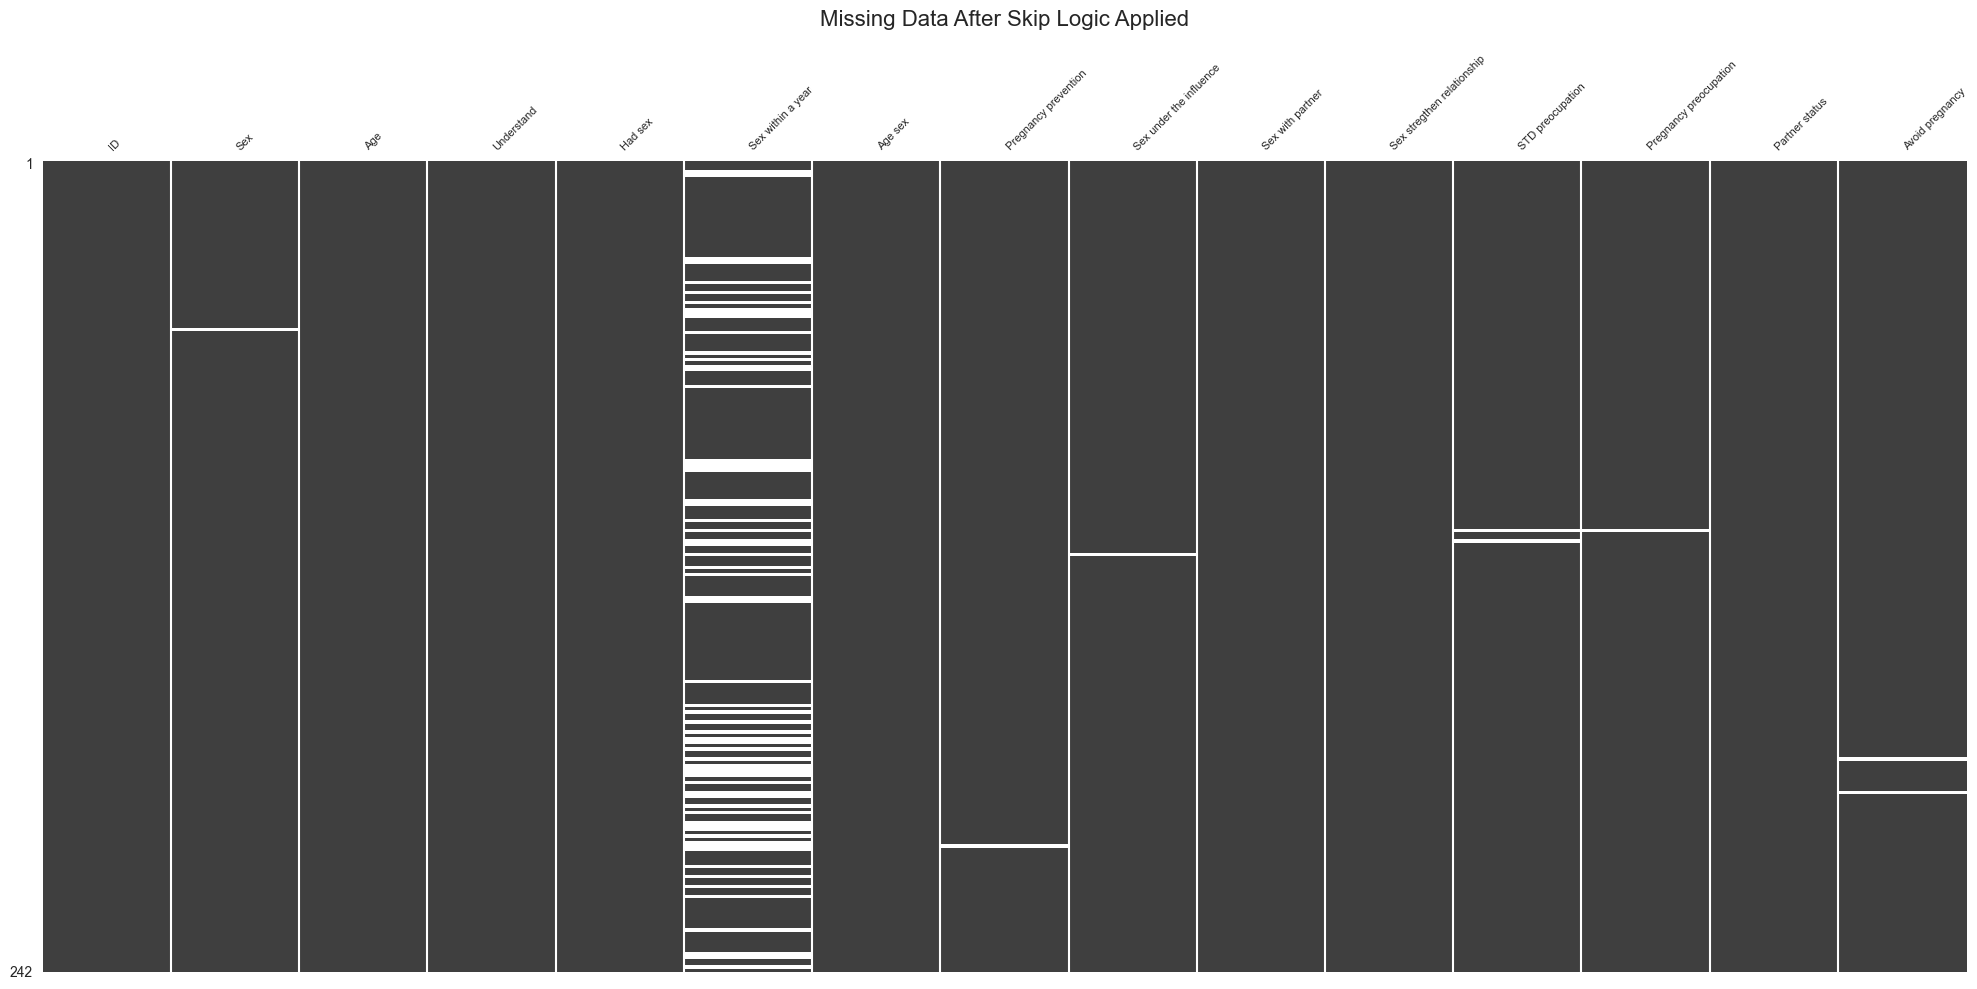


💡 Negative values now represent systematic skip patterns, not true missing data


In [ ]:
# Define skip logic function (from original 2021 preprocessing)
def replace_na_smart(base, column, value, fill_value, is_na):
    '''
    Replace missing values based on conditions.
    
    Parameters:
    - base: DataFrame to modify
    - column: Column to check for conditions
    - value: List of values to match (when is_na=False)
    - fill_value: Value to fill missing data with
    - is_na: If True, fill nulls; if False, fill based on value matches
    
    Returns:
    - Modified DataFrame
    '''
    if is_na:
        # Fill all columns from 'column' onwards where 'column' is null
        base.loc[base[column].isnull(), column:] = base.loc[base[column].isnull(), column:].fillna(fill_value)
    else:
        # Fill all columns from 'column' onwards where 'column' matches values
        base.loc[base[column].isin(value), column:] = base.loc[base[column].isin(value), column:].fillna(fill_value)
    return base

# Define skip rules (EXACT replication from original 2021 code)
# Format: [column, values_to_check, fill_value, is_null_check]
skip_rules = [
    ['Understand', [2.0], -1, False],             # Doesn't understand → skip all after
    ['Understand', [2.0], -2, True],              # Null on Understand → code as -2
    ['Had sex', [2.0], -3, False],                # Hasn't had sex → skip sex questions
    ['Had sex', [2.0], -2, True],                 # Null on Had sex → code as -2
    ['Had sex', [3.0, 4.0, 5.0], -4, False],      # Refused/don't know → code as -4
    ['Sex with partner', [2.0], -5, False],       # No sex with partner → skip
    ['Sex with partner', [3.0, 4.0, 5.0], -6, False],  # Refused partner Q → code as -6
    ['Sex with partner', [2.0], -2, True],        # Null on Sex with partner → code as -2
    ['Partner status', [7.0, 8.0, 9.0, 10.0, 11.0], -7, False],  # No partner → skip
    ['Partner status', [7.0, 8.0, 9.0, 10.0, 11.0], -2, True]    # Null on Partner status → code as -2
]

# Apply all skip rules
print("Applying skip logic rules...")
print("="*70)
aux = preguntas_base_df.copy()

for i, rule in enumerate(skip_rules):
    aux = replace_na_smart(aux, rule[0], rule[1], rule[2], rule[3])
    
print(f"✓ Skip logic applied: {len(skip_rules)} rules processed")
print(f"✓ Remaining TRUE missing values: {aux.isnull().sum().sum()}")

# Visualize after skip logic
msno.matrix(aux, figsize=(20, 10), fontsize=8, sparkline=False)
plt.title('Missing Data After Skip Logic Applied (Negative = Systematic Skip)', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

print("\n💡 Negative values now represent systematic skip patterns (not true missing)")
print("   Next step: Filter participants with >50% TRUE missing data")

## 4. Filter Participants with >50% Missing Data

**Thesis Decision:** After applying skip logic, eliminate any participant with more than 50% of targeted behavioral questions unanswered.

This ensures sufficient data quality for Factor Analysis by removing participants who provided minimal survey responses.

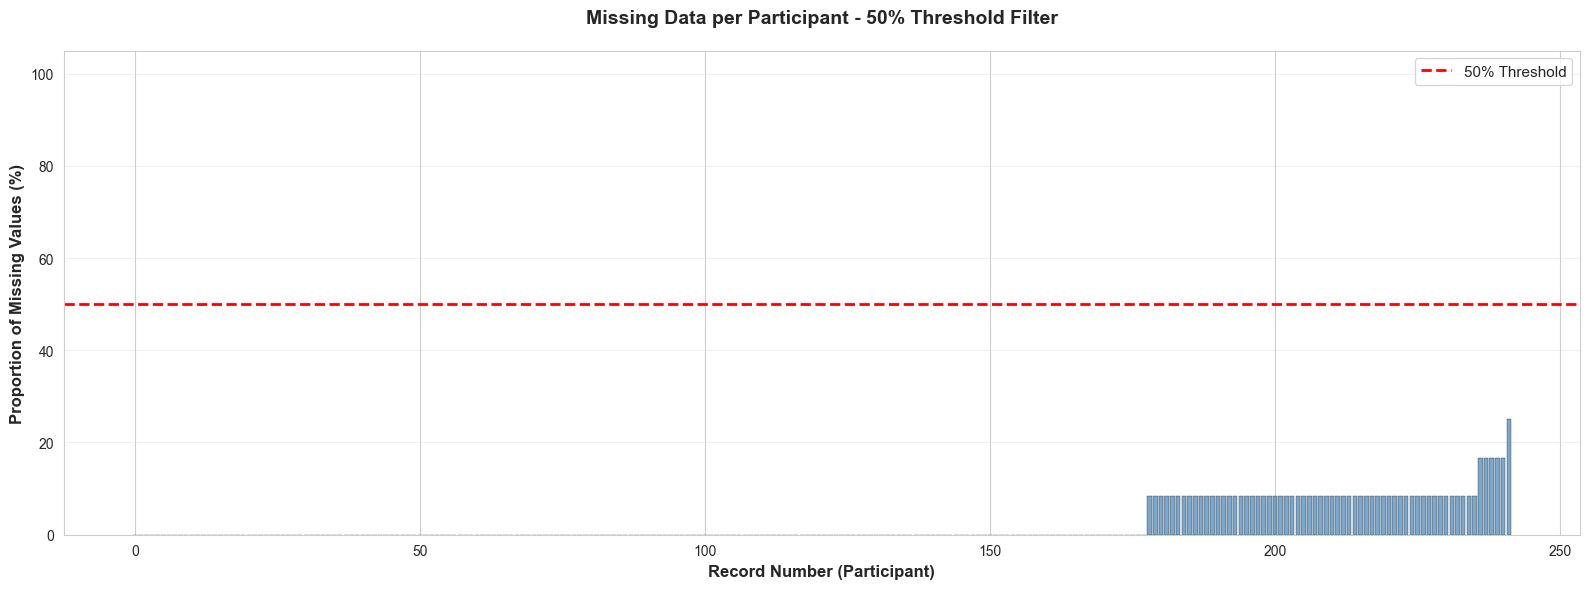


📊 Participant Missing Data Analysis:
Total participants: 242
Participants with >50% missing (red): 0 (0.0%)
Participants with ≤50% missing (blue): 242 (100.0%)

⚠️  Removing 0 participants with insufficient data...

✓ Filtered dataset: 242 participants remaining
  This represents 100.0% of original sample


In [ ]:
# Calculate proportion of TRUE missing values per participant (after skip logic)
# Focus on behavioral questions (exclude ID, Sex, Age)
behavioral_cols = aux.columns[3:]  # All questions after demographics
n_behavioral_questions = len(behavioral_cols)

# Calculate % TRUE missing for each participant (nulls, NOT negative codes)
missing_per_participant = aux[behavioral_cols].isnull().sum(axis=1) / n_behavioral_questions
missing_per_participant_sorted = missing_per_participant.sort_values()
missing_per_participant_pct = missing_per_participant_sorted * 100

# Create visualization showing SORTED participants by missing %
fig, ax = plt.subplots(figsize=(16, 6))

# Determine colors: red for >50%, blue for <=50%
colors = ['red' if x > 50 else 'steelblue' for x in missing_per_participant_pct]

# Plot bars
x_values = range(len(missing_per_participant_pct))
ax.bar(x_values, missing_per_participant_pct, color=colors, alpha=0.7, edgecolor='black', linewidth=0.3)

# Add 50% threshold line
ax.axhline(y=50, color='red', linestyle='--', linewidth=2.5, label='50% Threshold', zorder=10)

# Styling
ax.set_xlabel('Record Number (Sorted by Missing %)', fontsize=12, fontweight='bold')
ax.set_ylabel('Proportion of Missing Values (%)', fontsize=12, fontweight='bold')
ax.set_title('TRUE Missing Data per Participant (After Skip Logic) - 50% Threshold Filter', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, 105)
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate statistics
n_above_threshold = (missing_per_participant > 0.5).sum()
n_below_threshold = (missing_per_participant <= 0.5).sum()

print(f"\n📊 Participant Filtering Analysis:")
print("="*70)
print(f"Total participants (after skip logic): {len(aux)}")
print(f"Participants with >50% TRUE missing (red): {n_above_threshold} ({n_above_threshold/len(aux)*100:.1f}%)")
print(f"Participants with ≤50% TRUE missing (blue): {n_below_threshold} ({n_below_threshold/len(aux)*100:.1f}%)")

if n_above_threshold > 0:
    print(f"\n⚠️  Removing {n_above_threshold} participants with insufficient data...")
    # Filter dataset - keep aux for next steps
    aux = aux[missing_per_participant <= 0.5].copy()
    aux.reset_index(drop=True, inplace=True)
    print(f"✓ Filtered dataset: {len(aux)} participants remaining")
else:
    print(f"\n✅ No participants removed - all provided sufficient data")
    print(f"   (Skip logic successfully handled systematic missing patterns)")

print(f"\n💡 Final sample: {len(aux)} participants ({len(aux)/242*100:.1f}% of original N=242)")
print(f"   Continuing with categorical recoding...")

## 5. Collapse Categorical Variables

**After skip logic and filtering:** Reduce response categories for better factor analysis performance.

**Recoding Strategy:**
- Binary questions: Yes/No → 1/2, else → 3 (other/refused/NA)
- Ordinal scales: Collapse to 2-3 meaningful levels
- Remove extreme/outlier categories
- Convert negative codes to appropriate categories


In [ ]:
print("Collapsing categorical variables...")
print("="*70)

# Store the filtered data from previous step as our working copy
# aux already contains data after skip logic + filtering

# 1. Understand: Convert -2 back to 2.0 (No)
aux.loc[aux['Understand'] == -2, 'Understand'] = 2.0
print("✓ 1. Understand: -2 → 2.0 (No)")

# 2. Had sex: Collapse to 3 categories (Yes=1, No=2, Other=3)
aux.loc[~aux['Had sex'].isin([1, 2]), 'Had sex'] = 3.0
print("✓ 2. Had sex: Collapsed to 3 categories")

# 3. Sex within a year: Collapse to 3 levels
col = 'Sex within a year'
aux.loc[(aux[col] > 0) & (aux[col] < 4), col] = 1.0  # Definitely/probably yes
aux.loc[aux[col].isin([4, 5]), col] = 2.0             # Maybe/uncertain
aux.loc[~aux[col].isin([1, 2]), col] = 3.0            # No/refused/NA
print("✓ 3. Sex within a year: Collapsed to 3 levels")

# 4. Age sex: Collapse outliers
col = 'Age sex'
aux.loc[(aux[col] < 0) | (aux[col] > 7.0), col] = 7.0  # NA or >17 years
print("✓ 4. Age sex: Outliers collapsed")

# 5. Pregnancy prevention: Binary + other
col = 'Pregnancy prevention'
aux.loc[~aux[col].isin([1, 2]), col] = 3.0
print("✓ 5. Pregnancy prevention: Binary + other")

# 6. Sex under influence: Binary + other
col = 'Sex under the influence'
aux.loc[~aux[col].isin([1, 2]), col] = 3.0
print("✓ 6. Sex under influence: Binary + other")

# 7. Sex with partner: Binary + other
col = 'Sex with partner'
aux.loc[~aux[col].isin([1, 2]), col] = 3.0
print("✓ 7. Sex with partner: Binary + other")

# 8. Sex strengthen relationship: Binary + other
col = 'Sex stregthen relationship'
aux.loc[~aux[col].isin([1, 2]), col] = 3.0
print("✓ 8. Sex strengthen relationship: Binary + other")

# 9. STD preoccupation: Collapse to 3 levels (Low, Medium, High/NA)
col = 'STD preocupation'
aux.loc[(aux[col] > 0) & (aux[col] < 3), col] = 1.0   # Not concerned
aux.loc[(aux[col] > 2) & (aux[col] < 5), col] = 2.0   # Somewhat concerned
aux.loc[~aux[col].isin([1, 2]), col] = 3.0             # Very concerned/NA
print("✓ 9. STD preoccupation: 3 levels")

# 10. Pregnancy preoccupation: Collapse to 3 levels
col = 'Pregnancy preocupation'
aux.loc[(aux[col] > 0) & (aux[col] < 3), col] = 1.0
aux.loc[(aux[col] > 2) & (aux[col] < 5), col] = 2.0
aux.loc[~aux[col].isin([1, 2]), col] = 3.0
print("✓ 10. Pregnancy preoccupation: 3 levels")

# 11. Partner status: Collapse to 3 categories
col = 'Partner status'
aux.loc[(aux[col] > 0) & (aux[col] < 7), col] = 1.0   # Has partner
aux.loc[(aux[col] > 6) & (aux[col] < 9), col] = 2.0   # No partner
aux.loc[~aux[col].isin([1, 2]), col] = 3.0             # Other/refused
print("✓ 11. Partner status: 3 categories")

# 12. Avoid pregnancy: Binary + other
col = 'Avoid pregnancy'
aux.loc[~aux[col].isin([1, 2]), col] = 3.0
print("✓ 12. Avoid pregnancy: Binary + other")

print("\n✓ All 12 variables recoded successfully!")

Applying skip logic rules...
✓ Skip logic applied to 10 rules
Remaining true missing values: 72


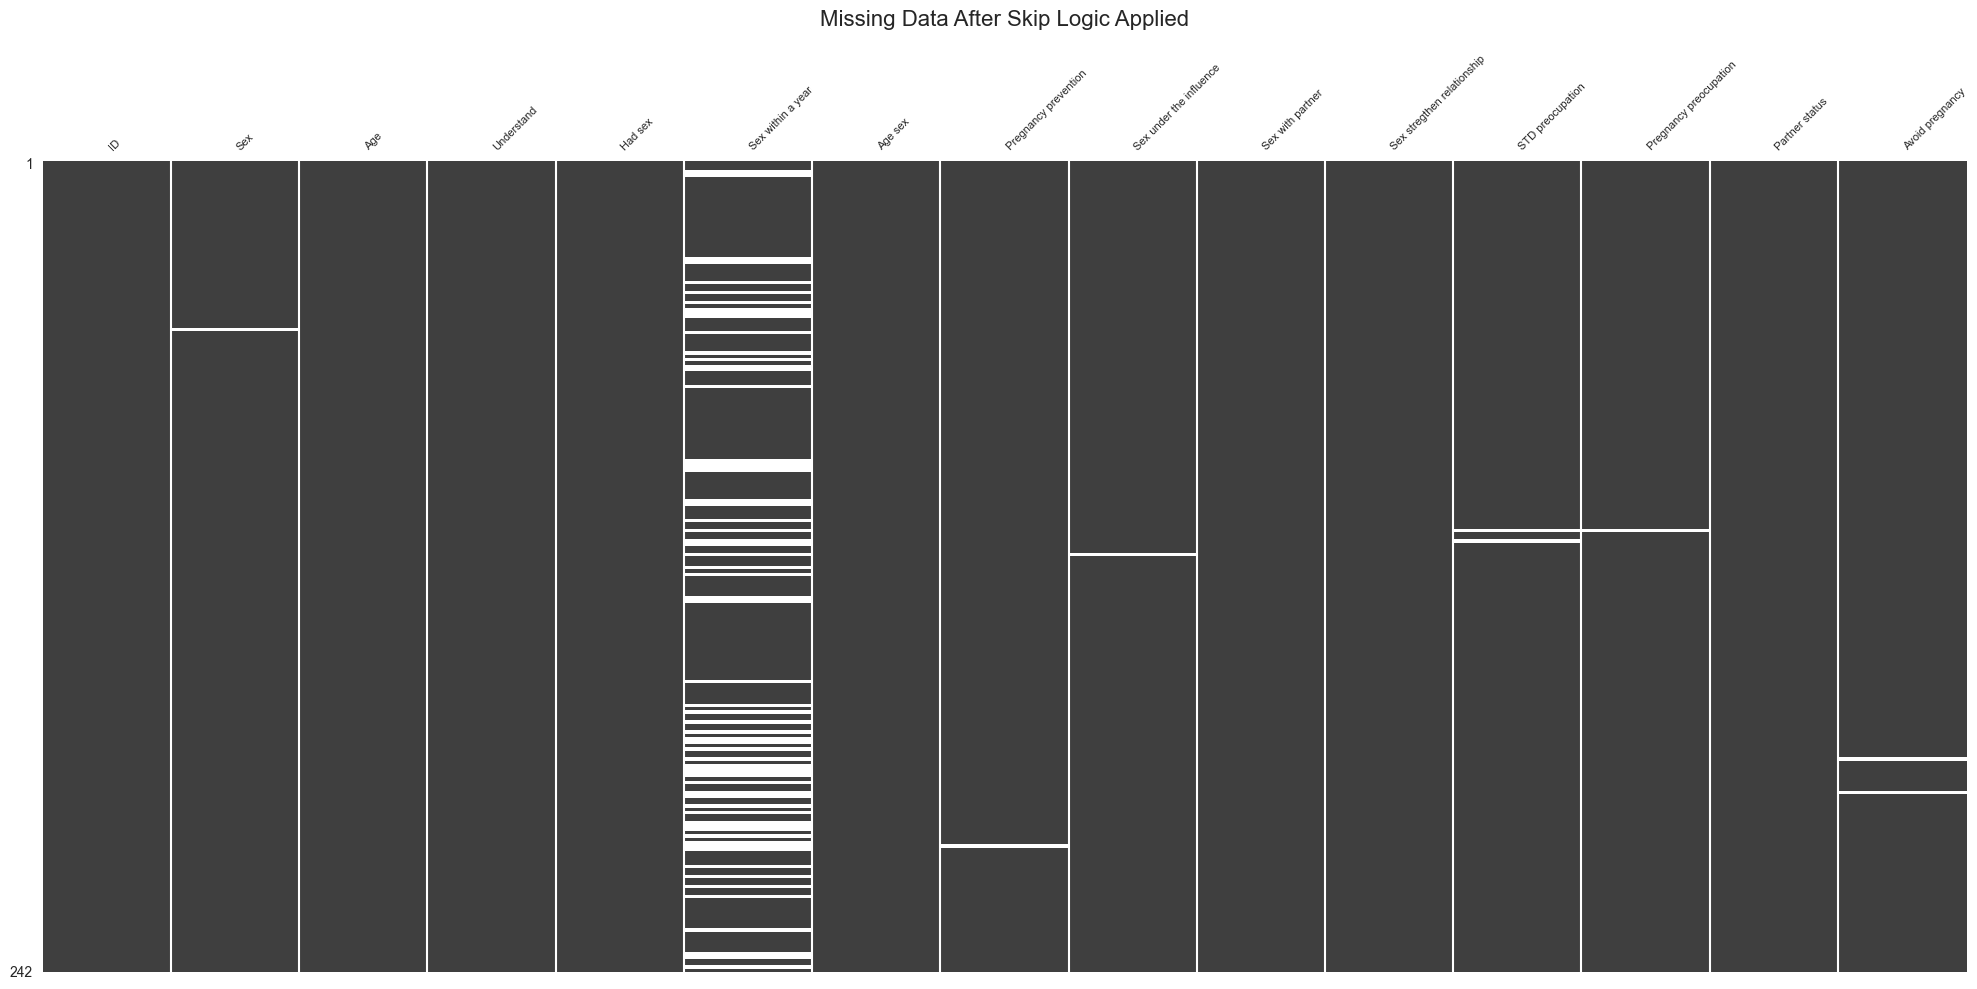


💡 Negative values now represent systematic skip patterns, not true missing data


In [26]:
# Visualize after skip logic
msno.matrix(aux, figsize=(20, 10), fontsize=8, sparkline=False)
plt.title('Missing Data After Skip Logic Applied', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

print("\n💡 Negative values now represent systematic skip patterns, not true missing data")


## 5. Collapse Categorical Variables

Reduce response categories for better factor analysis performance.

**Recoding Strategy:**
- Binary: Yes/No → 1/2, else → 3 (other/refused)
- Ordinal scales: Collapse to 2-3 levels
- Remove extreme/outlier categories


In [ ]:
print("Collapsing categorical variables...")
print("="*70)

# 1. Understand: Convert -2 back to 2.0 (No)
aux.loc[aux.Understand == -2, 'Understand'] = 2.0
print("✓ 1. Understand: -2 → 2.0 (No)")

# 2. Had sex: Collapse to 3 categories (Yes=1, No=2, Other=3)
aux.loc[~aux['Had sex'].isin([1, 2]), 'Had sex'] = 3.0
print("✓ 2. Had sex: Collapsed to 3 categories")

# 3. Sex within a year: Collapse to 3 levels
col = 'Sex within a year'
aux.loc[(aux[col] > 0) & (aux[col] < 4), col] = 1.0  # Definitely/probably yes
aux.loc[aux[col].isin([4, 5]), col] = 2.0             # Maybe/uncertain
aux.loc[~aux[col].isin([1, 2]), col] = 3.0            # No/refused/NA
print("✓ 3. Sex within a year: Collapsed to 3 levels")

# 4. Age sex: Collapse outliers
col = 'Age sex'
aux.loc[(aux[col] < 0) | (aux[col] > 7.0), col] = 7.0  # NA or >17 years
print("✓ 4. Age sex: Outliers collapsed")

# 5. Pregnancy prevention: Binary + other
col = 'Pregnancy prevention'
aux.loc[~aux[col].isin([1, 2]), col] = 3.0
print("✓ 5. Pregnancy prevention: Binary + other")

# 6. Sex under influence: Binary + other
col = 'Sex under the influence'
aux.loc[~aux[col].isin([1, 2]), col] = 3.0
print("✓ 6. Sex under influence: Binary + other")

# 7. Sex with partner: Binary + other
col = 'Sex with partner'
aux.loc[~aux[col].isin([1, 2]), col] = 3.0
print("✓ 7. Sex with partner: Binary + other")

# 8. Sex strengthen relationship: Binary + other
col = 'Sex stregthen relationship'
aux.loc[~aux[col].isin([1, 2]), col] = 3.0
print("✓ 8. Sex strengthen relationship: Binary + other")

# 9. STD preoccupation: Collapse to 3 levels (Low, Medium, High/NA)
col = 'STD preocupation'
aux.loc[(aux[col] > 0) & (aux[col] < 3), col] = 1.0   # Not concerned
aux.loc[(aux[col] > 2) & (aux[col] < 5), col] = 2.0   # Somewhat concerned
aux.loc[~aux[col].isin([1, 2]), col] = 3.0             # Very concerned/NA
print("✓ 9. STD preoccupation: 3 levels")

# 10. Pregnancy preoccupation: Collapse to 3 levels
col = 'Pregnancy preocupation'
aux.loc[(aux[col] > 0) & (aux[col] < 3), col] = 1.0
aux.loc[(aux[col] > 2) & (aux[col] < 5), col] = 2.0
aux.loc[~aux[col].isin([1, 2]), col] = 3.0
print("✓ 10. Pregnancy preoccupation: 3 levels")

# 11. Partner status: Collapse to 3 categories
col = 'Partner status'
aux.loc[(aux[col] > 0) & (aux[col] < 7), col] = 1.0   # Has partner
aux.loc[(aux[col] > 6) & (aux[col] < 9), col] = 2.0   # No partner
aux.loc[~aux[col].isin([1, 2]), col] = 3.0             # Other/refused
print("✓ 11. Partner status: 3 categories")

# 12. Avoid pregnancy: Binary + other
col = 'Avoid pregnancy'
aux.loc[~aux[col].isin([1, 2]), col] = 3.0
print("✓ 12. Avoid pregnancy: Binary + other")

print("\n✓ All 12 variables recoded successfully!")


In [ ]:
# Check recoding results
print("\nRecoded Value Distributions:")
print("="*70)
for col in aux.columns[3:]:  # Skip ID, Sex, Age
    print(f"\n{col}:")
    print(aux[col].value_counts().sort_index())


## 6. Handle Remaining Missing Data with MICE

Use Multivariate Imputation by Chained Equations for any remaining true missing values.


In [ ]:
# Check for remaining missing values after skip logic, filtering, and recoding
print(f"Remaining TRUE missing values after recoding: {aux.isnull().sum().sum()}")
print()

if aux.iloc[:, 1:].isnull().any().any():
    print("Applying MICE imputation...")
    print("="*70)
    
    # Initialize imputer (from original 2021 code)
    imp = IterativeImputer(max_iter=10, random_state=0)
    
    # Fit on complete cases (excluding ID column)
    complete_cases = aux[~aux.iloc[:, 1:].isnull().any(axis=1)].iloc[:, 1:]
    imp.fit(complete_cases)
    print(f"✓ MICE model trained on {len(complete_cases)} complete cases")
    
    # Transform incomplete cases
    incomplete_cases = aux[aux.iloc[:, 1:].isnull().any(axis=1)]
    
    if len(incomplete_cases) > 0:
        print(f"✓ Imputing {len(incomplete_cases)} incomplete cases...")
        X_test = incomplete_cases.iloc[:, 1:]
        data_imp = np.round(imp.transform(X_test))  # Round to get integer categories
        
        # Replace imputed values in dataframe
        index_imp = incomplete_cases.index
        aux.iloc[index_imp, 1:] = data_imp
        
        print(f"✓ Successfully imputed {len(incomplete_cases)} participants")
    
    print(f"\n✅ Final missing values: {aux.isnull().sum().sum()}")
else:
    print("✅ No remaining missing values - no imputation needed!")
    print("   (Skip logic successfully handled all missing patterns)")


In [ ]:
# Visualize final clean data (should show no missing)
msno.matrix(aux, figsize=(20, 10), fontsize=8, sparkline=False)
plt.title('Final Clean Data After All Processing (No Missing Values)', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

print("\n✅ Data cleaning complete! Dataset ready for Factor Analysis.")


## 7. Export Clean Data for Factor Analysis


In [ ]:
# Export cleaned data for Factor Analysis
output_file = '../Data/1_Preprocess/datos_preprocesados_FA.csv'
aux.to_csv(output_file, index=False)

print(f"✓ Clean data exported successfully!")
print(f"\n📁 File: {output_file}")
print(f"\n📊 Final Dataset Summary:")
print(f"  - Total participants: {len(aux)} (from original N=242)")
print(f"  - Variables: {len(aux.columns)} (ID + Sex + Age + 12 behavioral)")
print(f"  - Missing values: {aux.isnull().sum().sum()} ✅")
print(f"  - Data quality: Ready for Factor Analysis!")
print(f"\n➡️  Next step: Notebook 3 - Factor Analysis & Clustering")


## Summary

### Data Cleaning Process Completed:

1. ✅ **Loaded raw data:** 242 participants, 15 variables
2. ✅ **Skip logic applied:** 10 rules with negative value coding
3. ✅ **Participant filtering:** Removed participants with >50% missing behavioral data
4. ✅ **Variables recoded:** 12 categorical variables collapsed to 2-3 levels
5. ✅ **MICE imputation:** Remaining missing values imputed
6. ✅ **Quality verified:** No missing values, distributions checked
7. ✅ **Data exported:** Ready for Factor Analysis

---

### Data Transformations Summary:

| Variable | Original Categories | Final Categories | Rationale |
|----------|-------------------|------------------|-----------|
| Understand | 2 + missing | 2 (Yes/No) | Binary outcome |
| Had sex | 5 + missing | 3 (Yes/No/Other) | Simplified |
| Sex within year | 7 | 3 (Yes/Maybe/No) | Ordinal collapsed |
| Age sex | 8 + outliers | 7 + NA | Outlier handling |
| Prevention/Protection vars | Varied | 3 (Yes/No/Other) | Standardized |
| Concern variables | 6-point scales | 3 (Low/Med/High) | Simplified |
| Partner status | 11 | 3 (Has/None/Other) | Collapsed |

---

### Next Steps:

**Notebook 3: Factor Analysis & Clustering**
1. Test data suitability (Bartlett's, KMO)
2. Extract latent factors
3. Apply 8 clustering algorithms
4. Evaluate with 3 indices (Silhouette, Calinski-Harabasz, Davies-Bouldin)
5. Select optimal 5 clusters

---

**Clean data location:** `../Data/1_Preprocess/datos_preprocesados_FA.csv`

# Notebook 2: Data Cleaning & Preprocessing

**Preparing Data for Factor Analysis**

This notebook handles missing data, recodes variables, and prepares the dataset for Factor Analysis. The cleaned data will be used to extract latent factors representing underlying sexual behavior dimensions.

---

## Objective

Transform raw survey data into analysis-ready format by:
1. Handling systematic skip logic in survey questions
2. Imputing remaining missing values using MICE
3. Recoding categorical variables appropriately
4. Standardizing response scales
5. Exporting clean data for Factor Analysis

---

**Author:** Isabella Rodas  
**Institution:** Universidad de los Andes  
**Date:** 2021 (Analysis) | October 2025 (Documentation)
